In [1]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks/'

/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks


In [2]:
repo_dir = '/mmfs1/data/aglinska/BC-MRI-AE/'

In [3]:
import pickle

import numpy as np
import pandas as pd 

from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models;reload(make_models);from make_models import *

from functools import partial
from sklearn.decomposition import PCA
import scipy
from matplotlib import pyplot as plt
from sklearn.mixture import BayesianGaussianMixture as bnpc

import shutil
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [4]:
%%time 
import ants

CPU times: user 1.18 s, sys: 483 ms, total: 1.66 s
Wall time: 5.4 s


In [5]:
# LOAD ABIDE DATA
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'

ABIDE_data = np.load(dataFnOut)['data']
df = pd.read_csv(dfFnOut)

patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2
abide_asd = ABIDE_data[patients,:,:,:]

In [6]:
# LOAD SFARI 
arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

In [7]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=1
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'

loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

ready
loading


In [8]:
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)

fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'
loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

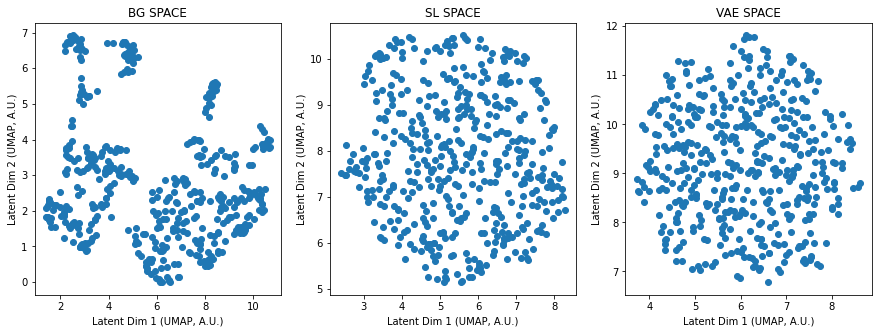

In [9]:
ofdir = '/mmfs1/data/aglinska/BC-MRI-AE/Data/'
embedded_data = pickle.load(open(os.path.join(ofdir,'embedded_data.pickle'),'rb'))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(embedded_data['bg_space_abide'][:,0],embedded_data['bg_space_abide'][:,1])
#plt.scatter(bg_space_sfari[:,0],bg_space_sfari[:,1])
#plt.legend(['ABIDE','SFARI']);
plt.title('BG SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,2)
plt.scatter(embedded_data['sl_space_abide'][:,0],embedded_data['sl_space_abide'][:,1])
#plt.scatter(sl_space_sfari[:,0],sl_space_sfari[:,1])
#plt.legend(['ABIDE','SFARI']);
plt.title('SL SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,3)
plt.scatter(embedded_data['vae_space_abide'][:,0],embedded_data['vae_space_abide'][:,1])
#plt.scatter(vae_space_sfari[:,0],vae_space_sfari[:,1])
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')
#plt.legend(['ABIDE','SFARI']);
plt.title('VAE SPACE')
plt.savefig('/mmfs1/data/aglinska/figures/spaces_abide.png',dpi=300)

In [10]:
def inverse_tx_umap(targ,s_embedding):
    targ = np.array(targ)
    idx = np.argsort(((s_embedding-targ)**2).sum(axis=1))
    return idx

def get_umap_corners(s_embedding):
    ax_min = s_embedding.min(axis=0)
    ax_max = s_embedding.max(axis=0)
    ax_mid = s_embedding.mean(axis=0)
    
#     ll = inverse_tx_umap((ax_min[0],ax_min[1]),s_embedding)
#     lr = inverse_tx_umap((ax_max[0],ax_min[1]),s_embedding)
#     tl = inverse_tx_umap((ax_min[0],ax_max[1]),s_embedding)
#     tr = inverse_tx_umap((ax_max[0],ax_max[1]),s_embedding)

    L = inverse_tx_umap((ax_min[0],ax_mid[1]),s_embedding)
    R = inverse_tx_umap((ax_max[0],ax_mid[1]),s_embedding)
    T = inverse_tx_umap((ax_mid[0],ax_max[1]),s_embedding)
    B = inverse_tx_umap((ax_mid[0],ax_min[1]),s_embedding)
    
    cntr = inverse_tx_umap(s_embedding.mean(axis=0),s_embedding)
    
    map_ = dict()
#     map_['ll'] = ll
#     map_['lr'] = lr
#     map_['tr'] = tr
#     map_['tl'] = tl

    map_['L'] = L
    map_['R'] = R
    map_['T'] = T
    map_['B'] = B
    map_['center'] = cntr

    return map_

def get_brain_pair(b_vec,s_vec):
    
    vec_asd = np.hstack((b_vec,s_vec))
    vec_td = np.hstack((b_vec,np.zeros(16)))

    im_asd = cvae_decoder.predict(np.vstack((vec_asd,vec_asd)))[0,:,:,:,0]
    im_td = cvae_decoder.predict(np.vstack((vec_td,vec_td)))[0,:,:,:,0]
    
    thresh = 0.0
    im_asd[im_asd<thresh]=0
    im_td[im_td<thresh]=0
    
    nii_asd = template.new_image_like(im_asd)
    nii_td = template.new_image_like(im_td)
    
    nii_asd.set_origin(tuple(np.array(nii_asd.origin)-np.array(nii_asd.get_center_of_mass())))
    nii_td.set_origin(tuple(np.array(nii_asd.origin)-np.array(nii_asd.get_center_of_mass())))
    
    return nii_td,nii_asd

def clean_tx_folder(tx):
    [os.remove(f) for f in np.unique(np.vstack((np.array(tx['fwdtransforms']),np.array(tx['invtransforms']))))];

In [11]:
template = ants.image_read('/mmfs1/data/aglinska/BC-ASD-FC/Atlas/Atlas_brain_2mm.nii')
template = ants.resample_image(template,(64,64,64),use_voxels=True,interp_type=4)

In [12]:
space_bg = embedded_data['embedding_bg']
space_sl = embedded_data['embedding_sl']

In [13]:
map_ = get_umap_corners(embedded_data['sl_space_abide'])

In [14]:
def get_data(corner,idx,do_plot,normalize,vbm=False):
# 
# do_plot = True;normalize=False
    idx = map_[corner][idx]
    nii_td,nii_asd = get_brain_pair(space_bg[idx,:],space_sl[idx,:])

    if do_plot:
        nii_asd.plot_ortho((nii_td),overlay_alpha=.3,flat=True,title='TD and ASD sampled')

    outdir = '/data/aglinska/txs/'

    tx = ants.registration(fixed=nii_asd,moving=nii_td,type_of_transform='Rigid',outprefix=outdir)
    nii_td = ants.apply_transforms(fixed=nii_asd,moving=nii_td,transformlist=tx['fwdtransforms'],interpolator='bSpline')


    #clean_tx_folder(tx)

    if do_plot:
        nii_asd.plot_ortho((nii_td),overlay_alpha=.3,flat=True,title='TD and ASD rigid aligned')

    if normalize:
        
#        native_asd = nii_asd.copy()
#        native_td = nii_asd.copy()

        templateTiny = template.resample_image((64,64,64), use_voxels=True, interp_type=4)
        templateTiny.set_origin(tuple(np.array(templateTiny.origin)-np.array(templateTiny.get_center_of_mass())))

        if do_plot:
            templateTiny.plot_ortho(overlay=nii_asd,overlay_alpha=.3,flat=True,title='template overlay asd')

        txR2T = ants.registration(fixed=templateTiny,moving=nii_td,type_of_transform='Rigid',outprefix=outdir)
        nii_td = ants.apply_transforms(fixed=templateTiny,moving=nii_td,transformlist=txR2T['fwdtransforms'],interpolator='bSpline')
        nii_asd = ants.apply_transforms(fixed=templateTiny,moving=nii_asd,transformlist=txR2T['fwdtransforms'],interpolator='bSpline')

        if do_plot:
            templateTiny.plot_ortho(overlay=nii_td,overlay_alpha=.3,flat=True,title='template overlay ASD rigid')
        
        if vbm==False:
            txNorm = ants.registration(fixed=templateTiny,moving=nii_asd,type_of_transform='SyN',outprefix=outdir)
            nii_td = ants.apply_transforms(fixed=templateTiny,moving=nii_td,transformlist=txNorm['fwdtransforms'],interpolator='bSpline')
            nii_asd = ants.apply_transforms(fixed=templateTiny,moving=nii_asd,transformlist=txNorm['fwdtransforms'],interpolator='bSpline')
            
        elif vbm==True:
            txNorm = ants.registration(fixed=templateTiny,moving=nii_asd,type_of_transform='SyN',outprefix=outdir)
            nii_asd = ants.apply_transforms(fixed=templateTiny,moving=nii_asd,transformlist=txNorm['fwdtransforms'],interpolator='bSpline')
            
            txNorm = ants.registration(fixed=templateTiny,moving=nii_td,type_of_transform='SyN',outprefix=outdir)
            nii_td = ants.apply_transforms(fixed=templateTiny,moving=nii_td,transformlist=txNorm['fwdtransforms'],interpolator='bSpline')
            #nii_asd = ants.apply_transforms(fixed=templateTiny,moving=nii_asd,transformlist=txNorm['fwdtransforms'],interpolator='bSpline')
        
        

        if do_plot:
            templateTiny.plot_ortho((nii_asd),overlay_alpha=.3,flat=True,title='template overlay ASD SyN')


    # WARP TD INTO ASD
    txT2A = ants.registration(fixed=nii_asd,moving=nii_td,type_of_transform='SyN',outprefix=outdir)

    # WANT JACOBIANS?
    J = ants.create_jacobian_determinant_image(nii_td,txT2A['fwdtransforms'][0])
    J1 = ants.create_jacobian_determinant_image(nii_td,txT2A['invtransforms'][1])

    # LOAD WARP as an image
    nii_tx = ants.image_read(txT2A['fwdtransforms'][0])

    if do_plot:
        (nii_asd-nii_td).plot_ortho(title='nii_asd-nii_td',flat=True)
    
    # CLEAN UP
    [os.remove(os.path.join(outdir,file)) for file in os.listdir(outdir)];

    #nii_td.to_filename('/mmfs1/data/aglinska/ims/nii_td.nii')
    #nii_asd.to_filename('/mmfs1/data/aglinska/ims/nii_asd.nii')
    #nii_tx.to_filename('/mmfs1/data/aglinska/ims/nii_tx.nii')
    
    data = {'nii_td' : nii_td, 'nii_asd' : nii_asd, 'J' : J, 'J1' : J1, 'nii_tx' : nii_tx}
    
    return data

In [15]:
#get_data('ll',0,do_plot=True,normalize=False):

In [16]:
def f(x,y,z):
    ''' return transformed coordinates'''
    i,j,k = np.array([x,y,z])+nii_tx.numpy()[x,y,z,:]
    return i,j,k

In [17]:
def get_C(x,y,z):
    J = np.zeros((3,3))
    J[:,0] = np.array(f(x,y,z))-np.array(f(x+1,y,z))
    J[:,1] = np.array(f(x,y,z))-np.array(f(x,y+1,z))
    J[:,2] = np.array(f(x,y,z))-np.array(f(x,y,z+1))
    
    C = np.matmul(J.transpose(),J)-np.eye(3)
    return C

In [20]:
nsamples = 50
dump_where = '/mmfs1/data/aglinska/Results/'
keys1 = ['L', 'R', 'T', 'B', 'cntr_']
keys2 = ['nii_td', 'nii_asd', 'J', 'J1', 'nii_tx']
from_dump = dict()
for i in tqdm(range(5)): # LOOP L R T B C
    groupData = list()
    for j in range(nsamples): # LOOP subjects
        subData = dict()
        for k in range(5): # LOOP subject data
            #pass
            ofn = os.path.join(dump_where,f'{keys1[i]}S{j}_{keys2[k]}.nii')
            #to_dump[keys1[i]][j][keys2[k]].to_filename(ofn)
            subData.update({keys2[k] : ants.image_read(ofn)})
        groupData.append(subData)
    from_dump.update({keys1[i] : groupData})
    
    
L = from_dump['L']
R = from_dump['R']
T = from_dump['T']
B = from_dump['B']
cntr_ = from_dump['cntr_']

100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


<ipython-input-21-f5cf869a344b>:36: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-21-f5cf869a344b>:44: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-21-f5cf869a344b>:52: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can 

<Figure size 1080x360 with 0 Axes>

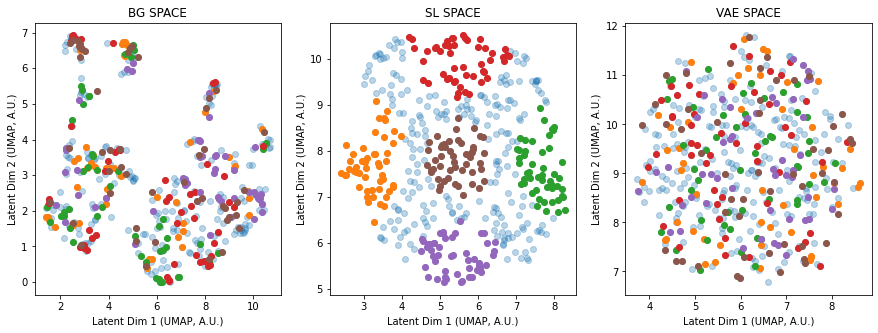

In [21]:
plt.figure(figsize=(15,5))


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(embedded_data['bg_space_abide'][:,0],embedded_data['bg_space_abide'][:,1],alpha=.3)
#plt.scatter(bg_space_sfari[:,0],bg_space_sfari[:,1])
#plt.legend(['ABIDE','SFARI']);
plt.title('BG SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,2)
plt.scatter(embedded_data['sl_space_abide'][:,0],embedded_data['sl_space_abide'][:,1],alpha=.3)
#plt.scatter(sl_space_sfari[:,0],sl_space_sfari[:,1])
#plt.legend(['ABIDE','SFARI']);
plt.title('SL SPACE')
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

plt.subplot(1,3,3)
plt.scatter(embedded_data['vae_space_abide'][:,0],embedded_data['vae_space_abide'][:,1],alpha=.3)
#plt.scatter(vae_space_sfari[:,0],vae_space_sfari[:,1])
plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
plt.ylabel('Latent Dim 2 (UMAP, A.U.)')
#plt.legend(['ABIDE','SFARI']);
plt.title('VAE SPACE')
#plt.savefig('/mmfs1/data/aglinska/figures/spaces_abide.png',dpi=300)


for key in list(map_.keys()):
    #slice_ = np.array([map_[key][0:nsamples] for key in list(map_.keys())]).flatten()
    slice_ = map_[key][0:nsamples]

    
    plt.subplot(1,3,1)
    plt.scatter(embedded_data['bg_space_abide'][slice_,0],embedded_data['bg_space_abide'][slice_,1])
    #plt.scatter(bg_space_sfari[:,0],bg_space_sfari[:,1])
    #plt.legend(['ABIDE','SFARI']);
    plt.title('BG SPACE')
    plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
    plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

    plt.subplot(1,3,2)
    plt.scatter(embedded_data['sl_space_abide'][slice_,0],embedded_data['sl_space_abide'][slice_,1])
    #plt.scatter(sl_space_sfari[:,0],sl_space_sfari[:,1])
    #plt.legend(['ABIDE','SFARI']);
    plt.title('SL SPACE')
    plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
    plt.ylabel('Latent Dim 2 (UMAP, A.U.)')

    plt.subplot(1,3,3)
    plt.scatter(embedded_data['vae_space_abide'][slice_,0],embedded_data['vae_space_abide'][slice_,1])
    #plt.scatter(vae_space_sfari[:,0],vae_space_sfari[:,1])
    plt.xlabel('Latent Dim 1 (UMAP, A.U.)')
    plt.ylabel('Latent Dim 2 (UMAP, A.U.)')
    #plt.legend(['ABIDE','SFARI']);
    plt.title('VAE SPACE')
plt.savefig('/mmfs1/data/aglinska/figures/spaces_abide_samples.png',dpi=300)

In [59]:
#dfr = pd.read_csv('~/BC-ASD-FC/Atlas/roinames.txt',index_col=None,header=None)
dfr = pd.read_csv('~/BC-MRI-AE/Data/neurosynth_maps/aal.nii.txt',index_col=None,header=None)
#rnames = np.array([dfr.values[r][0].replace("''",'').split('-') for r in range(50)])
#nets = np.unique(rnames[:,1])
#nets
dfr.head()

,0
0,1 Precentral_L 2001
1,2 Precentral_R 2002
2,3 Frontal_Sup_L 2101
3,4 Frontal_Sup_R 2102
4,5 Frontal_Sup_Orb_L 2111


In [99]:
for i in tqdm(range(116)):
    name = dfr.values[i][0].split()[1]
    rois_im = ants.image_read('~/BC-MRI-AE/Data/neurosynth_maps/aal.nii')
    rois = rois_im.copy()
    rois[rois.numpy()!=i+1]=0
    rois.to_filename(f'~/BC-MRI-AE/Data/aal/{name}.nii')

100%|██████████| 116/116 [00:35<00:00,  3.22it/s]


In [96]:
np.arrange()

'Precentral_L'

In [57]:
# map_ims = []
# rois_im = ants.image_read('~/BC-MRI-AE/Data/neurosynth_maps/aal.nii')
# #rois_im = ants.image_read('~/BC-ASD-FC/Atlas/Atlas_parc-7n_2mm.nii')
# roi_list = np.unique(rois_im.numpy())[np.unique(rois_im.numpy())!=0]
# for i in tqdm(roi_list):
#     rois = rois_im.copy()
#     rois[rois.numpy()!=(i+1)]=0
#     rois = rois.resample_image_to_target(template,interp_type=1)
#     map_ims.append(rois)

100%|██████████| 116/116 [00:11<00:00,  9.80it/s]


In [62]:
# maps = [val[0] for val in dfr.values]    

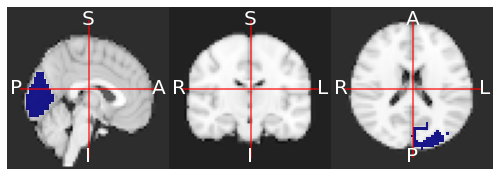

In [44]:
template.plot_ortho(map_ims[0],flat=True)

In [76]:
#map_dir = os.path.join(repo_dir,'Data','gene_epression_maps')
map_dir = os.path.join(repo_dir,'Data','neurosynth_maps','roi_mats')
maps = [f for f in os.listdir(map_dir) if f.endswith('.nii')]
maps.sort()
maps = maps[0:17]
map_ims = [ants.image_read(os.path.join(map_dir,maps[m])).resample_image_to_target(template) for m in range(len(maps))]
print(len(maps))

17


In [362]:
maps = [ 'motor cortex_association-test_z_FDR_0.01.nii.gz',
 'resting state_association-test_z_FDR_0.01.nii.gz',
 'cerebellum_association-test_z_FDR_0.01.nii.gz',
 'somatosensory_association-test_z_FDR_0.01.nii.gz',]

In [338]:
maps = [ 'social_association-test_z_FDR_0.01.nii.gz',
 'emotions_association-test_z_FDR_0.01.nii.gz',
 'face_association-test_z_FDR_0.01.nii.gz',
 'language_association-test_z_FDR_0.01.nii.gz']

In [77]:
nmaps = len(map_ims)
ncorners = 5
nsubs = nsamples
c_res = np.zeros((nmaps,ncorners,nsubs))


critVals = list()
for m in tqdm(range(nmaps)):
    im = map_ims[m]
    for s in range(nsubs):
        for c in range(ncorners):
            mat = [L,R,T,B,cntr_][c][s]['J1'].numpy()
            #vec1 = [L,R,T,B,cntr_][c][s]['J1'].numpy().flatten()
            #vec1 = [L,R,T,B,cntr_][c][s]['J1'].numpy().flatten()
            #vec1 = ([L,R,T,B,cntr_][c][s]['nii_asd']-[L,R,T,B,cntr_][c][s]['nii_td']).numpy().flatten()
            #vec2 = im.flatten()
            #c_res[m,c,s] = np.corrcoef(vec1,vec2)[0,1]
            #c_res[m,c,s] = mat[(im.numpy()>.2)].mean()-1
            nvox = 1000
            critVal = np.sort(im.numpy().flatten())[::-1][nvox]
            critVal=0
            c_res[m,c,s] = mat[(im.numpy()>critVal)].mean()-1

100%|██████████| 17/17 [00:17<00:00,  1.06s/it]


In [375]:
critVals = [np.sort(im.numpy().flatten())[::-1][nvox] for im in map_ims]
critVals

[0.0,
 0.0,
 0.0,
 0.30612448,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

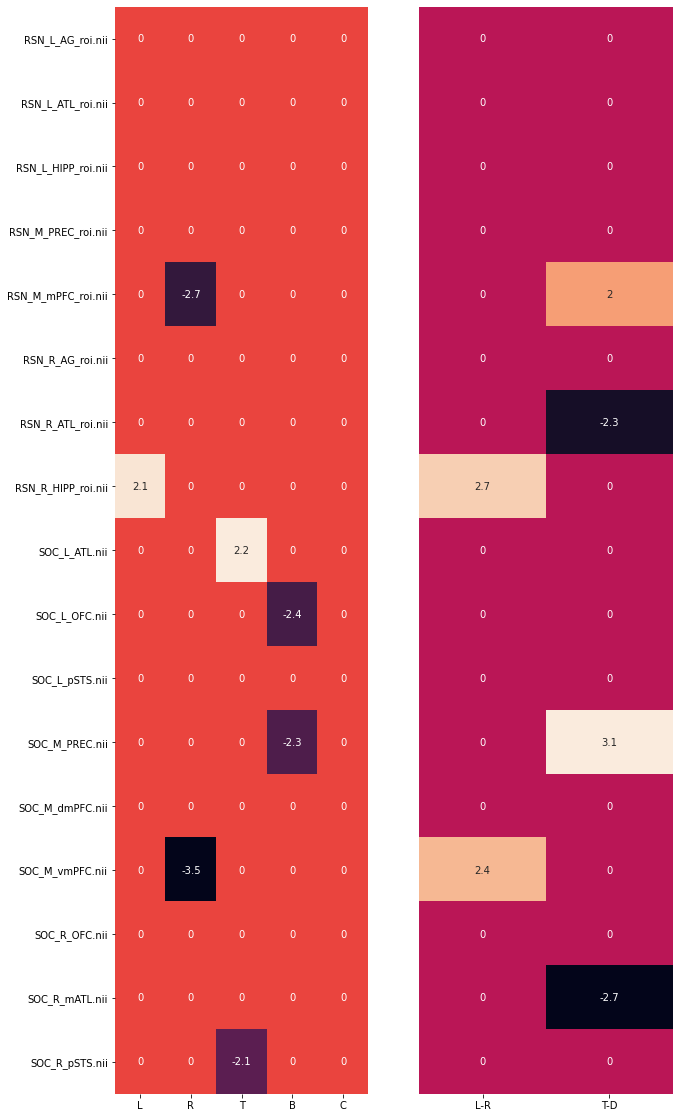

In [80]:
plt.figure(figsize=(10,20))
map_lbls = [mm.replace('_association-test_z_FDR_0.01.nii','').replace('v5-topics-50_','')[0::] for mm in maps]
#map_lbls = dfr.values
from scipy.stats import ttest_1samp,ttest_ind
                #plot_mat = (c_res-c_res[:,4,:][:,np.newaxis,:]).mean(axis=2)
    
thresh = 2;p_tresh = .05;s = 50
plt.subplot(1,2,1)
c_res_copy = c_res.copy()
c_res_copy = c_res_copy[:,:,:]
#plot_mat = ttest_1samp((c_res_copy-c_res_copy[:,4,:][:,np.newaxis,:]),0,axis=2)[0]
plot_mat = ttest_ind(c_res_copy[:,4,:][:,np.newaxis,:],c_res_copy,axis=2)[0]
pmat1 = ttest_ind(c_res_copy[:,4,:][:,np.newaxis,:],c_res_copy,axis=2)[1]

#plot_mat[abs(plot_mat)<thresh]=0
plot_mat[pmat1>p_tresh]=0


sns.heatmap(plot_mat,annot=True,cbar=False);

plt.yticks(np.arange(nmaps)+.5,labels=map_lbls,rotation=0);
plt.xticks(np.arange(ncorners)+.5,labels=['L','R','T','B','C'],rotation=0);


c_res_copy = c_res.copy()
c_res_copy = c_res_copy[:,:,:]

plt.subplot(1,2,2)
#ax_mat = np.array([ttest_1samp((c_res_copy[:,1,:]-c_res_copy[:,0,:]),0,axis=1)[0],ttest_1samp((c_res_copy[:,3,:]-c_res_copy[:,2,:]),0,axis=1)[0]])
ax_mat = np.array([ttest_ind(c_res_copy[:,1,:],c_res_copy[:,0,:],axis=1)[0],ttest_ind(c_res_copy[:,3,:],c_res_copy[:,2,:],axis=1)[0]])
pmat2 = np.array([ttest_ind(c_res_copy[:,1,:],c_res_copy[:,0,:],axis=1)[1],ttest_ind(c_res_copy[:,3,:],c_res_copy[:,2,:],axis=1)[1]])
ax_mat[pmat2>p_tresh]=0
#ax_mat[abs(ax_mat)<thresh]=0

sns.heatmap(ax_mat.transpose(),annot=True,cbar=False)
plt.yticks([]);
plt.xticks(np.arange(2)+.5,labels=['L-R','T-D'],rotation=0);

In [423]:
#[template.plot(map_ims[i],overlay_alpha=.5,slices=[15,25,30,32,40,45],title=map_lbls[i]) for i in range(nmaps)]

In [69]:
arrs = list()
arrs2 = list()
for mat in [L,R,T,B,cntr_]:
    arrs.append([(mat[i]['nii_asd'].get_mask()-mat[i]['nii_td'].get_mask()).numpy().sum() for i in tqdm(range(nsamples))])
    arrs2.append([(mat[i]['nii_asd']-mat[i]['nii_td']).numpy().sum() for i in range(nsamples)])

100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


<ErrorbarContainer object of 3 artists>

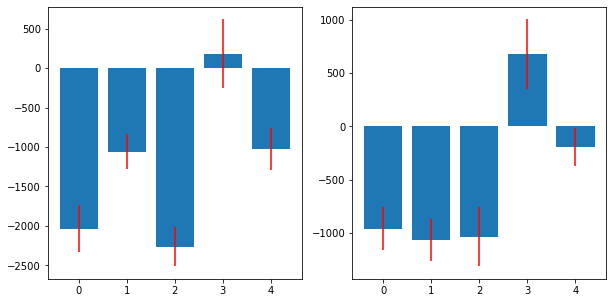

In [70]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
xs = np.arange(5)
m = np.array(arrs).mean(axis=1)
se = np.array(arrs).std(axis=1) / np.sqrt(50)
plt.bar(xs,m)
plt.errorbar(xs,m,se,fmt='r ')

plt.subplot(1,2,2)
xs = np.arange(5)
m = np.array(arrs2).mean(axis=1)
se = np.array(arrs2).std(axis=1) / np.sqrt(50)
plt.bar(xs,m)
plt.errorbar(xs,m,se,fmt='r ')

In [46]:
# nsamples = 50
# L = [get_data('L',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
# R = [get_data('R',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
# T = [get_data('T',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
# B = [get_data('B',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]
# cntr_ = [get_data('center',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]

100%|██████████| 50/50 [03:18<00:00,  3.97s/it]


In [ ]:
import pickle

In [26]:
#pickle.dump(L[0]['nii_td'],open('/mmfs1/data/aglinska/jacobians.pickle','wb'))
#to_dump = {'L':L,'R':R,'T':T,'B':B,'cntr_':cntr_}
dump_where = '/mmfs1/data/aglinska/Results/'

In [27]:
# dump_where = '/mmfs1/data/aglinska/Results/'
# keys1 = ['L', 'R', 'T', 'B', 'cntr_']
# keys2 = ['nii_td', 'nii_asd', 'J', 'J1', 'nii_tx']
# from_dump = dict()
# for i in tqdm(range(5)): # LOOP L R T B C
#     groupData = list()
#     for j in range(nsamples): # LOOP subjects
#         subData = dict()
#         for k in range(5): # LOOP subject data
#             #pass
#             ofn = os.path.join(dump_where,f'{keys1[i]}S{j}_{keys2[k]}.nii')
#             #to_dump[keys1[i]][j][keys2[k]].to_filename(ofn)
#             subData.update({keys2[k] : ants.image_read(ofn)})
#         groupData.append(subData)
#     from_dump.update({keys1[i] : groupData})

100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


In [107]:
#from_dump = dict()
#from_dump[keys1[i]][j][keys2[k]] = ants.image_read(ofn)

In [112]:
a = list()
a[0] = '1'
a[1] = '2'

IndexError: list assignment index out of range

In [18]:
# [(L[i]['J1']-1).to_filename(f'/mmfs1/data/aglinska/BC-MRI-AE/Results/jacobian/L{i}.nii') for i in range(nsamples)];
# [(R[i]['J1']-1).to_filename(f'/mmfs1/data/aglinska/BC-MRI-AE/Results/jacobian/R{i}.nii') for i in range(nsamples)];
# [(T[i]['J1']-1).to_filename(f'/mmfs1/data/aglinska/BC-MRI-AE/Results/jacobian/T{i}.nii') for i in range(nsamples)];
# [(B[i]['J1']-1).to_filename(f'/mmfs1/data/aglinska/BC-MRI-AE/Results/jacobian/B{i}.nii') for i in range(nsamples)];
# [(cntr_[i]['J1']-1).to_filename(f'/mmfs1/data/aglinska/BC-MRI-AE/Results/jacobian/cntr_{i}.nii') for i in range(nsamples)];

In [30]:
outside = template.get_mask().numpy().flatten()==0

In [31]:
for idx,col in enumerate([L,R,T,B,cntr_]):
    c_name = ['L','R','T','B','cntr_'][idx]
    for i in range(nsamples):
        im = col[i]
        im = im['J1']
        im = im-1
        im[outside.reshape(64,64,64)]=0
        #im.to_filename(f'/mmfs1/data/aglinska/BC-MRI-AE/Results/jacobian/{c_name}{i}.nii')
        im.to_filename(f'/mmfs1/data/aglinska/Results/jacobian/{c_name}{i}.nii')

In [109]:
#!zip -r '/mmfs1/data/aglinska/Results.zip' '/mmfs1/data/aglinska/Results/'

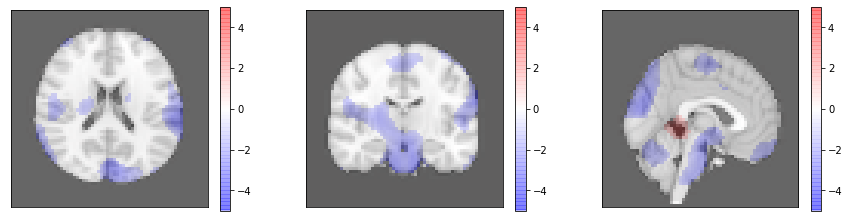

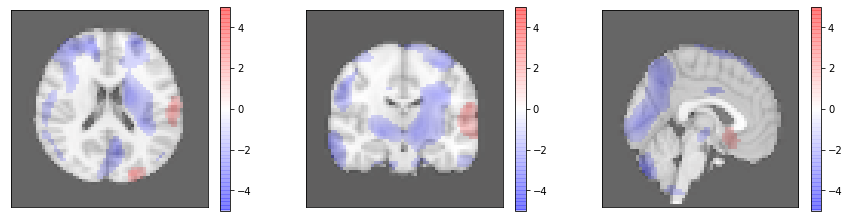

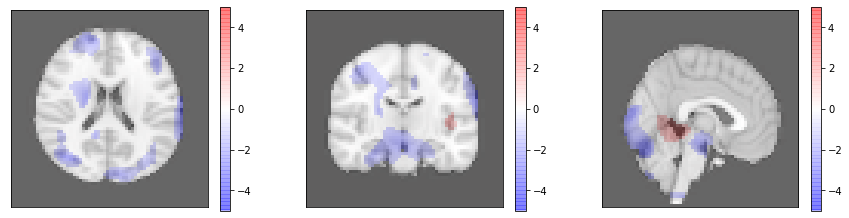

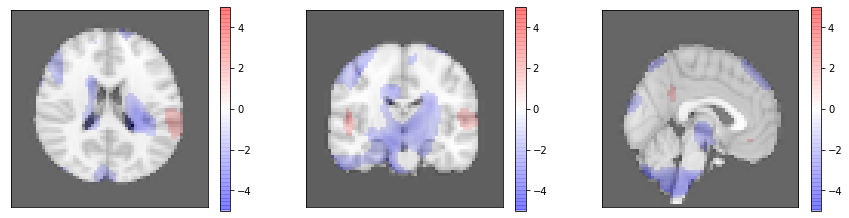

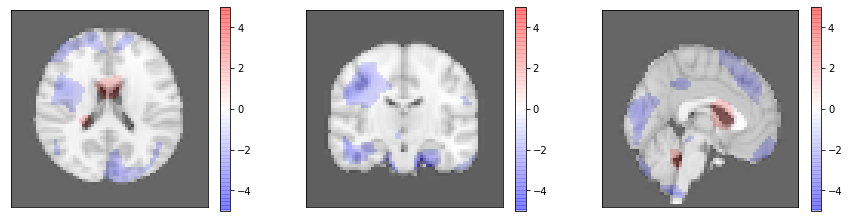

In [39]:
c = 10
#for mat in [ll,lr,tl,tr,cntr_]:
res = list()
for mat in [L,R,T,B,cntr_]:
    c+=1
    clim = (None,None)
    clim = (-5,5)
    
    arr = np.array([l['J1'].numpy() for l in mat])-1
    arr = arr.reshape(nsamples,-1)

    #tmat = arr.mean(axis=0) / (arr.std(axis=0)+1)

    tmat = ttest_1samp(arr,0)[0]
    tmat[np.isnan(tmat)]=0
    tmat[abs(tmat)<2.2]=0
    tmat[outside] = 0

    im = template
    ol = template.new_image_like(tmat.reshape(64,64,64))
    res.append(ol)
    plot_ortho(im,ol,i=32,j=32,k=32,clim=clim)
    
    #ol.to_filename(f'/mmfs1/data/aglinska/ims/newJ{c}.nii')

In [334]:
arr.shape
from scipy.stats import ttest_ind

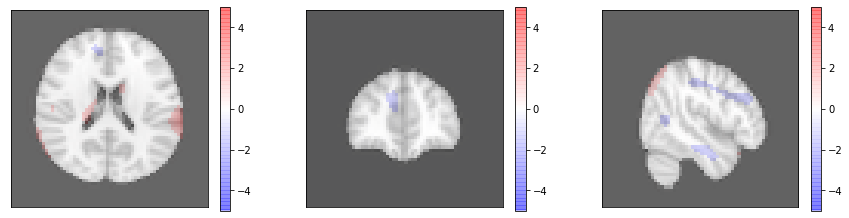

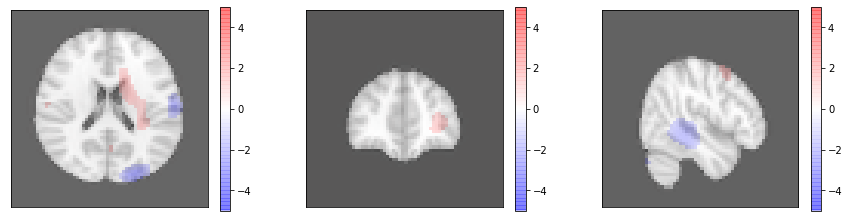

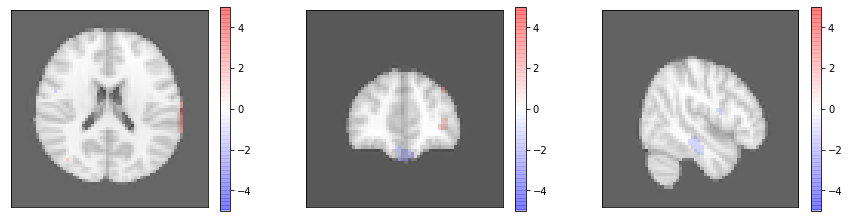

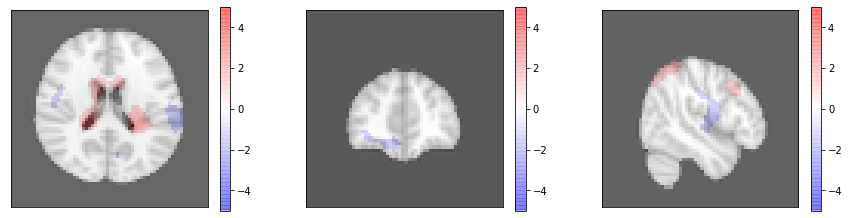

In [370]:
c = 10
#for mat in [ll,lr,tl,tr,cntr_]:
res = list()
for mat in [L,R,T,B]:
    c+=1
    clim = (None,None)
    clim = (-5,5)
    
    arr = np.array([l['J1'].numpy() for l in mat])-1
    arr = arr.reshape(nsamples,-1)

    cc = (np.array([l['J1'].numpy() for l in cntr_])-1).reshape(nsamples,-1)

    tmat = ttest_ind(cc,arr)[0]
    tmat[np.isnan(tmat)]=0
    tmat[abs(tmat)<2.2]=0
    tmat[outside] = 0

    im = template
    ol = template.new_image_like(tmat.reshape(64,64,64))
    res.append(ol)
    plot_ortho(im,ol,i=15,j=50,k=32,clim=clim)
    
    #ol.to_filename(f'/mmfs1/data/aglinska/ims/newJ{c}.nii')

In [210]:
#rois = ants.image_read('/mmfs1/data/aglinska/BC-ASD-FC/Atlas/Atlas_parc-7n_2mm.nii')
rois = ants.image_read('/mmfs1/data/aglinska/BC-MRI-AE/Data/aal.nii')
tx = ants.registration(fixed=template,moving=rois,type_of_transform='Rigid')
rois = ants.apply_transforms(fixed=template,moving=rois,
    transformlist=tx['fwdtransforms'],
    interpolator='genericLabel')

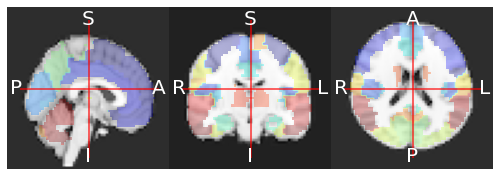

In [211]:
template.plot_ortho(rois,flat=True,overlay_alpha=.3)

In [222]:
rnames = pd.read_table('/mmfs1/data/aglinska/BC-MRI-AE/Data/aal.nii.txt',names=['idx','name','num'],delimiter=' ')
rnames.head()

,idx,name,num
0,1,Precentral_L,2001
1,2,Precentral_R,2002
2,3,Frontal_Sup_L,2101
3,4,Frontal_Sup_R,2102
4,5,Frontal_Sup_Orb_L,2111


In [223]:
[29,30]

[29, 30]

In [137]:
mat = np.array([L[i]['J1'].numpy()-1 for i in range(nsamples)])
net_idxs = np.isin(rois.numpy(),np.nonzero(np.isin(rnames['net'],nets[0]))).flatten()
(mat.reshape(10,-1)[:,net_idxs]).mean(axis=1)

array([ 0.0190592 , -0.02823389, -0.05379357, -0.05483736, -0.08579231,
       -0.05238201, -0.05583472,  0.00994106, -0.03312469,  0.00444285],
      dtype=float32)

In [299]:
nets = [[77,78],np.arange(91,108)]

In [300]:
list(rnames['name'].values[nets[0]])

['Thalamus_R', 'Heschl_L']

In [302]:
enumerate?

Init signature: enumerate(iterable, start=0)
Docstring:     
Return an enumerate object.

  iterable
    an object supporting iteration

The enumerate object yields pairs containing a count (from start, which
defaults to zero) and a value yielded by the iterable argument.

enumerate is useful for obtaining an indexed list:
    (0, seq[0]), (1, seq[1]), (2, seq[2]), ...
Type:           type
Subclasses:     


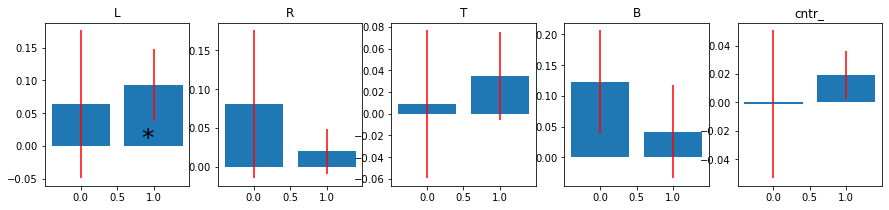

In [321]:
plt.figure(figsize=(15,3))
for c,group in enumerate([L,R,T,B,cntr_]):
    
    plt.subplot(1,5,c+1)
    mat = np.array([group[i]['J1'].numpy()-1 for i in range(nsamples)])
    n = len(nets)
    #arr = np.array([(mat.reshape(10,-1)[:,np.isin(rois.numpy(),np.nonzero(np.isin(rnames['net'],nets[i]))).flatten()]).mean(axis=1) for i in range(7)])
    arr = np.array([(mat.reshape(10,-1)[:,np.isin(rois.numpy(),nets[i]).flatten()]).mean(axis=1) for i in range(n)])
    arr = -arr
    #arr = arr-arr.mean(axis=0)

    xs = np.arange(n)
    m = arr.mean(axis=1)
    se = arr.std(axis=1) / np.sqrt(10) * 3.17

    plt.bar(xs,m);
    plt.errorbar(xs,m,se,fmt='r ');
    #plt.xticks(xs,labels=nets,rotation=45);
    #plt.ylim(-0.08,.02)
    plt.title(['L','R','T','B','cntr_'][c])
    sig = [ttest_1samp(arr[i,:],0)[1]<.001 for i in range(n)]
    [plt.text(i-.17,0,'*',fontsize=25) for i in np.nonzero(sig)[0]]

In [451]:
data = SFARI_data[(sfari_subs_del),:,:,:]
space_sl = s_encoder.predict(data)[w]
space_bg = z_encoder.predict(data)[w]

reducer = umap.UMAP(n_components=2)
s_embedding = reducer.fit_transform(space_sl)

del_16p = [get_data('center',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]


data = SFARI_data[(sfari_subs_dupl),:,:,:]
space_sl = s_encoder.predict(data)[w]
space_bg = z_encoder.predict(data)[w]

reducer = umap.UMAP(n_components=2)
s_embedding = reducer.fit_transform(space_sl)

dupl_16p = [get_data('center',i,do_plot=False,normalize=True) for i in tqdm(range(nsamples))]

100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


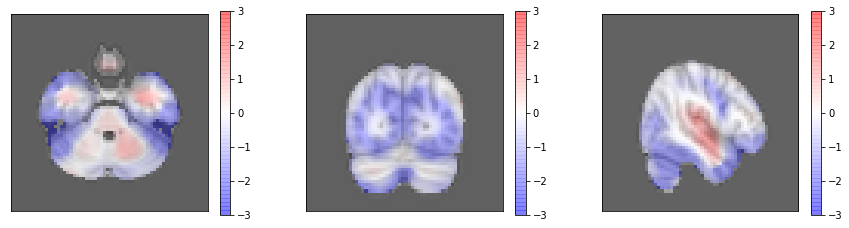

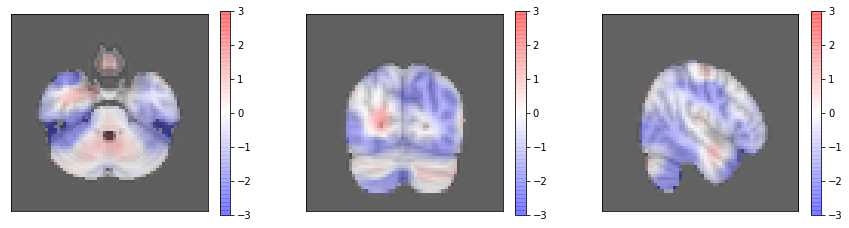

In [457]:
c = 10
#for mat in [ll,lr,tl,tr,cntr_]:
for mat in [del_16p,dupl_16p]:
    c+=1
    clim = (None,None)
    clim = (-3,3)
    
    arr = np.array([l['J1'].numpy() for l in mat])-1
    arr = arr.reshape(nsamples,-1)

    #tmat = arr.mean(axis=0) / (arr.std(axis=0)+1)

    tmat = ttest_1samp(arr,0)[0]
    tmat[np.isnan(tmat)]=0
    #tmat[abs(tmat)<2.2]=0
    tmat[outside] = 0

    im = template
    ol = template.new_image_like(tmat.reshape(64,64,64))
    plot_ortho(im,ol,i=15,j=15,k=15,clim=clim)
    
    ol.to_filename(f'/mmfs1/data/aglinska/ims/{c}.nii')

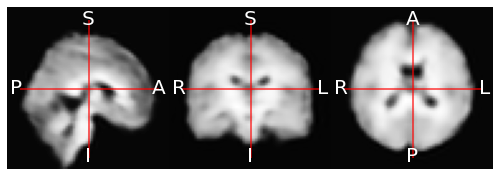

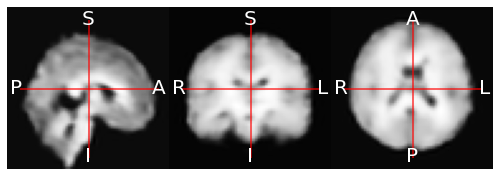

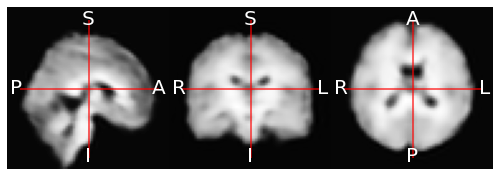

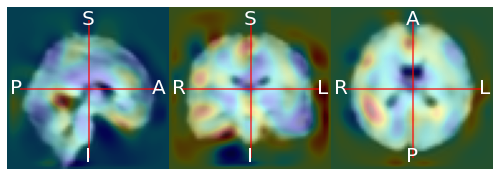

In [466]:
del_16p[0]['nii_td'].plot_ortho(flat=True)
del_16p[0]['nii_asd'].plot_ortho(flat=True)
del_16p[0]['nii_td'].plot_ortho(flat=True)

del_16p[0]['nii_td'].plot_ortho(del_16p[0]['J1'],flat=True,overlay_alpha=.3)

In [38]:
def plot_ortho(im,ol,i=32,j=32,k=32,clim=(None,None)):
    
    #i,j,k = 32,32,32
    vmin = clim[0];vmax = clim[1]
    im_ax = im.numpy()[:,:,k];im_ax = np.rot90(im_ax)
    im_cor = im.numpy()[:,j,:];im_cor = np.rot90(im_cor)
    im_sag = im.numpy()[i,:,:];im_sag = np.rot90(im_sag)

    ol_ax = ol.numpy()[:,:,k];ol_ax = np.rot90(ol_ax)
    ol_cor = ol.numpy()[:,j,:];ol_cor = np.rot90(ol_cor)
    ol_sag = ol.numpy()[i,:,:];ol_sag = np.rot90(ol_sag)

    ims = [im_ax,im_cor,im_sag]
    ols = [ol_ax,ol_cor,ol_sag]

    plt.figure(figsize=(15,5))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(ims[i],cmap='gray')
        plt.imshow(ols[i],cmap='bwr',alpha=.3,vmin=vmin,vmax=vmax)
        #plt.imshow(ols[i],cmap='coolwarm',alpha=.3,vmin=vmin,vmax=vmax)
        cbar = plt.colorbar(shrink=.75);plt.xticks([]);plt.yticks([]);

'/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks'

In [421]:
for i in tqdm(range(100)):
    data = get_data('center',i,do_plot=False,normalize=True,vbm=True)
    data['nii_td'].to_filename(f'/mmfs1/data/aglinska/data_for_VBM/TD_{i}.nii')
    data['nii_asd'].to_filename(f'/mmfs1/data/aglinska/data_for_VBM/ASD_{i}.nii')
    (data['nii_asd']-data['nii_td']).to_filename(f'/mmfs1/data/aglinska/data_for_VBM/diff_{i}.nii')

100%|██████████| 100/100 [09:20<00:00,  5.60s/it]


In [432]:
i = 80

im_td = ants.image_read(f'/mmfs1/data/aglinska/data_for_VBM/TD_{i}.nii')
im_td[im_td.get_mask().numpy()<1]=0
im_td = im_td.smooth_image(sigma=3,sigma_in_physical_coordinates=False,FWHM=True, max_kernel_width=32)
im_td.plot()y



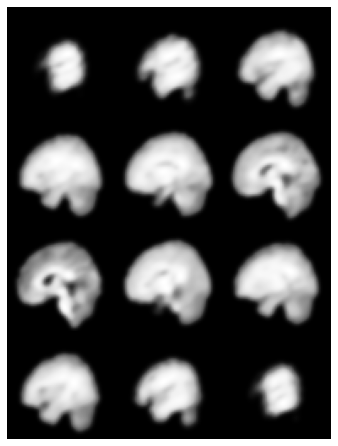